## Daniel Suañez Ramirez PS4
### A simple wealth model

We built stochastic endowment economy with perfect aggregation. The recursive household problem given prices, is the following:

\begin{equation}
\max_{a'}  V(a, y) = u(wy + (1+r)a - a') + \beta \sum_{y} \pi_{y'|y}V(a',y') \\ 
\text{subject to} \\
a' \geq \bar{A}_{i} \text{ for } i = 1,2 \text{ and } c\geq 0\\
\end{equation}

Where the borrowing limit, $\bar{A}_{i}$ can be:

$1) \bar{A}_{1} \geq -\dfrac{y_{i}}{r}$

$2) \bar{A}_{2} \geq 0$

Takin the derivative with respect to $a'$:
\begin{equation}
u'_{c}(c) =\beta \sum_{y} \pi_{y'|y}V'(a',y')
\end{equation}

We apply the envelope theorem, that is, the derivative of the value function with respect to state variable is the derivative of the utility with respect to that state variable. So, we arrive to:

\begin{equation}
V'(a,y) = u_{c}(c)(1+r) \Longrightarrow V'(a',y') = u_c(c')(1+r_{t+1})
\end{equation}

Finally, we arrive to the Euler equation:

\begin{equation}
u_{c} (c) = \beta \sum_{y'} \pi_{y'|y}u_{c}(c')(1+r_{t+1}) 
\end{equation}

The income follow a sthocastic two-state process:

$y_{t} = \{1-\sigma, 1+\sigma\}$


In [2]:
# Import packages

import numpy as np
from numpy import vectorize
from itertools import product
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import BSpline
from scipy.interpolate import interp1d

In [ ]:
# Parametrization of the model:

ro = 0.06
beta = 1/(1+ro)
w = 1
r = 0.04
gamma = 0.5
sigmay = 0.2

# Transition matrix for the Markov Process

pi = np.array([((1+gamma)/2, (1-gamma)/2),((1-gamma)/2, (1+gamma)/2)])


## Quadractic Utility
II.2 - The infinitely-lived households economy 

In [13]:
Y = (1-sigmay, 1+sigmay)

cbar = 100*Y[1]     # parameter for avoiding saturation of any consumer

A = np.linspace(((-(1+r)/r)*Y[0]), 30, 80)    # grid over assets tomorrow

ay = list(product(Y, A, A))
ay = np.array(ay)

y = ay[:, 0]
ai = ay[:, 1]
aj = ay[:, 2]

c = y+(1+r)*ai-aj

@vectorize
    
def M(c):
    
    return -0.5*(c-cbar)**2
     
M = M(c)
M = np.reshape(M, (1, 12800))
M = np.reshape(M, (160, 80))

# Initial guess for the value function is a vector of zeros:

Vs = np.zeros(160)

# Compute the matrix W:

def W1(A):   
    
    return pi[0, 0]*(-0.5*(Y[0] + (1+r)*A - A - cbar)**2)/(1-beta) + pi[0, 1]*(-0.5*(Y[1] + (1+r)*A - A - cbar)**2)/(1-beta)

def W2(A):
    
    return pi[1, 0]*(-0.5*(Y[0] + (1+r)*A - A - cbar)**2)/(1-beta) + pi[1, 1]*(-0.5*(Y[1] + (1+r)*A - A - cbar)**2)/(1-beta)

        
W1 = W1(A)
W1 = np.reshape(W1, (80,1))
W1 = np.tile(W1, 80)
W1 = np.transpose(W1)

W2 = W2(A)
W2 = np.reshape(W2, (80,1))
W2 = np.tile(W2, 80)
W2 = np.transpose(W2)

W = [W1, W2]
W = np.reshape(W, (160,80))

# Compute the matrix X:

X = M + beta*W

Vs1 = np.amax(X, axis = 1)

diffVs = Vs - Vs1

count = 0

# If differences are larger than 1, we iterate taking as new value functions 
# Vs1 up to obtain convergence:

for diffVs in range(1, 8000):
    
    Vss = Vs1
    Vs = [Vss[0:80], Vss[80:]]
    Vs = np.array(Vs)
    
    def W1(Vs):
        
        return pi[0, 0]*Vs[0, :] + pi[0, 1]*Vs[1, :]
    
    def W2(Vs):
        
        return pi[1, 0]*Vs[0, :] + pi[1, 1]*Vs[1, :]

    W1 = W1(Vs)
    W1 = np.reshape(W1, (1,80))
    W1 = np.tile(W1, 80)
    W1 = np.reshape(W1, (80,80))

    W2 = W2(Vs)
    W2 = np.reshape(W2, (1,80))
    W2 = np.tile(W2, 80)
    W2 = np.reshape(W2, (80,80))
    
    W = [W1, W2]
    W = np.reshape(W, (160, 80))
    
    X = M + beta*W
    
    Vs1 = np.amax(X, axis = 1)
    
    diffVs = Vss - Vs1
    
    count += 1

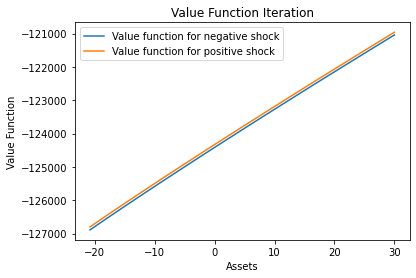

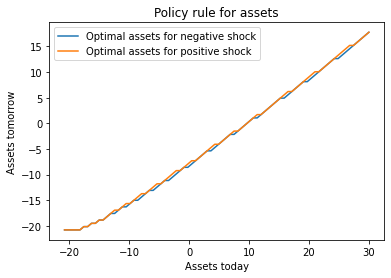

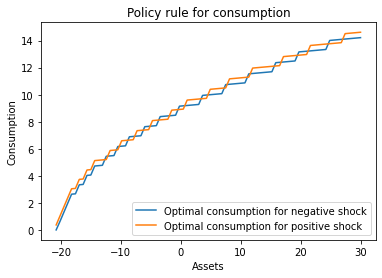

In [14]:
# Once we obtain convergence, redefine the matrix X:
    
X = M + beta*W

# The value function given different realizations of y:

V_y1 = Vs1[0:80]
V_y2 = Vs1[80:]

# Now we can obtain the decision rule, which give us column number that
# maximizes row i of the X matrix:

g = np.argmax(X, axis = 1)

# For the first 45 periods:

aopt_y1 = A[g[0:80]]     # optimal decision of assets given y1
aopt_y2 = A[g[80:]]    # optimal decision of assets given y2

c_y1 = Y[0]*np.ones(80) + (1+r)*A - aopt_y1

c_y2 = Y[1]*np.ones(80) + (1+r)*A - aopt_y2

for i in range(0, 80):
    
    if c_y1[i] < 0:
        
        c_y1[i] = 0
        
    if c_y2[i] < 0:
        
        c_y2[i] = 0
           
# Plot the value function and the optimal policy:
    
plt.figure()
plt.plot(A, V_y1, label = 'Value function for negative shock')
plt.plot(A, V_y2, label = 'Value function for positive shock')
plt.title('Value Function Iteration')
plt.legend()
plt.ylabel('Value Function')
plt.xlabel('Assets')
plt.show()
    
plt.figure()
plt.plot(A, aopt_y1, label = 'Optimal assets for negative shock')
plt.plot(A, aopt_y2, label = 'Optimal assets for positive shock')
plt.title('Policy rule for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y1, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y2, label = 'Optimal consumption for positive shock')
plt.title('Policy rule for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

II.3 - The life-cycle economy (Backwards)

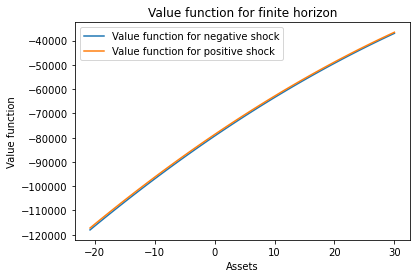

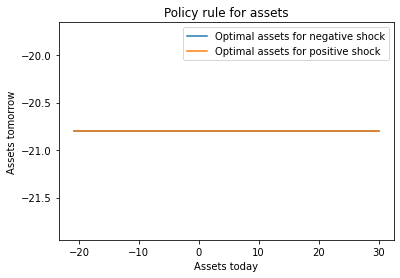

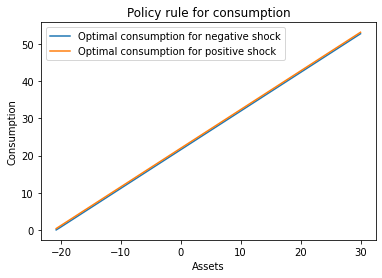

In [15]:
W = np.zeros((160, 80))

count = 0

while count < 45:
    
    W = np.amax((M + beta*W), axis = 1)
    W = np.reshape(W,(160, 1))
    W = W*np.ones((160, 80))
    
    count += 1

plt.plot(A, W[0:80, 0], label = 'Value function for negative shock')
plt.plot(A, W[80:, 0], label = 'Value function for positive shock')
plt.legend()
plt.title('Value function for finite horizon')
plt.ylabel('Value function')
plt.xlabel('Assets')
plt.show()

X = M + beta*W
g = np.argmax(X, axis = 1)

aopt_y1 = A[g[0:80]]     # optimal decision of assets given y1
aopt_y2 = A[g[80:]]      # optimal decision of assets given y2

c_y1 = Y[0]*np.ones(80) + (1+r)*A - aopt_y1

c_y2 = Y[1]*np.ones(80) + (1+r)*A - aopt_y2

for i in range(0, 80):
    
    if c_y1[i] < 0:
        
        c_y1[i] = 0
        
    if c_y2[i] < 0:
        
        c_y2[i] = 0
        
plt.figure()
plt.plot(A, aopt_y1, label = 'Optimal assets for negative shock')
plt.plot(A, aopt_y2, label = 'Optimal assets for positive shock')
plt.legend()
plt.title('Policy rule for assets')
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y1, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y2, label = 'Optimal consumption for positive shock')
plt.title('Policy rule for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()


# CRRA Utility

II.2 - The infinitely-lived households economy

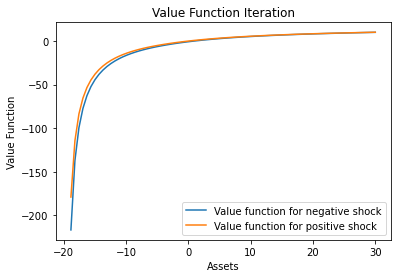

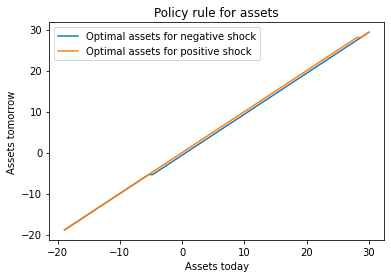

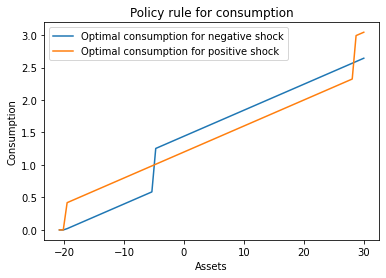

In [17]:
sigma = 2

A = np.linspace(((-(1+r)/r)*Y[0]), 30, 80)    # grid over assets tomorrow

ay = list(product(Y, A, A))
ay = np.array(ay)

y = ay[:, 0]
ai = ay[:, 1]
aj = ay[:, 2]

c = y + (1+r)*ai - aj
        
M = np.zeros(12800)

for i in range(0, 12800):
    
    if c[i] >= 0:
        
        M[i] = ((c[i]**(1-sigma))-1)/(1-sigma)
        
    if c[i] < 0:
        
        M[i] = -100000

M = np.reshape(M, (1, 12800))        
M = np.reshape(M, (160, 80))

# Initial guess for the value function is a vector of zeros:

Vs = np.zeros(160)

# Compute the matrix W:

def W1(A):   
    
    return pi[0, 0]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-sigma)*(1-beta)) + pi[0, 1]*(((Y[1] + (1+r)*A - A)**(1-sigma))-1)/((1-sigma)*(1-beta))

def W2(A):
    
    return pi[1, 0]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-sigma)*(1-beta)) + pi[1, 1]*(((Y[1] + (1+r)*A - A)**(1-sigma))-1)/((1-sigma)*(1-beta))

        
W1 = W1(A)
W1 = np.reshape(W1, (80,1))
W1 = np.tile(W1, 80)
W1 = np.transpose(W1)

W2 = W2(A)
W2 = np.reshape(W2, (80,1))
W2 = np.tile(W2, 80)
W2 = np.transpose(W2)

W = [W1, W2]
W = np.reshape(W, (160,80))

# Compute the matrix X:

X = M + beta*W

Vs1 = np.amax(X, axis = 1)

diffVs = Vs - Vs1

count = 0

# If differences are larger than 1, we iterate taking as new value functions 
# Vs1 up to obtain convergence:

for diffVs in range(1, 8000):
    
    Vss = Vs1
    Vs = [Vss[0:80], Vss[80:]]
    Vs = np.array(Vs)
    
    def W1(Vs):
        
        return pi[0, 0]*Vs[0, :] + pi[0, 1]*Vs[1, :]
    
    def W2(Vs):
        
        return pi[1, 0]*Vs[0, :] + pi[1, 1]*Vs[1, :]

    W1 = W1(Vs)
    W1 = np.reshape(W1, (1,80))
    W1 = np.tile(W1, 80)
    W1 = np.reshape(W1, (80,80))

    W2 = W2(Vs)
    W2 = np.reshape(W2, (1,80))
    W2 = np.tile(W2, 80)
    W2 = np.reshape(W2, (80,80))
    
    W = [W1, W2]
    W = np.reshape(W, (160, 80))
    
    X = M + beta*W
    
    Vs1 = np.amax(X, axis = 1)
    
    diffVs = Vss - Vs1
    
    count += 1
    

# Once we obtain convergence, redefine the matrix X:
    
X = M + beta*W

# The value function given different realizations of y:

V_y1 = Vs1[0:80]
V_y2 = Vs1[80:]

# Now we can obtain the decision rule, which give us column number that
# maximizes row i of the X matrix:

g = np.argmax(X, axis = 1)

# For the first 45 periods:

aopt_y1 = A[g[0:80]]     # optimal decision of assets given y1
aopt_y2 = A[g[80:]]    # optimal decision of assets given y2

for i in range(0, 2):
    
    aopt_y1[i] = 0
    aopt_y2[i] = 0
    

c_y1 = Y[0]*np.ones(80) + (1+r)*A - aopt_y1

c_y2 = Y[1]*np.ones(80) + (1+r)*A - aopt_y2

for i in range(0, 80):
    
    if c_y1[i] < 0:
        
        c_y1[i] = 0
        
    if c_y2[i] < 0:
        
        c_y2[i] = 0
           
# Plot the value function and the optimal policy:
    
plt.figure()
plt.plot(A[3:], V_y1[3:], label = 'Value function for negative shock')
plt.plot(A[3:], V_y2[3:], label = 'Value function for positive shock')
plt.title('Value Function Iteration')
plt.legend()
plt.ylabel('Value Function')
plt.xlabel('Assets')
plt.show()
    
plt.figure()
plt.plot(A[3:], aopt_y1[3:], label = 'Optimal assets for negative shock')
plt.plot(A[3:], aopt_y2[3:], label = 'Optimal assets for positive shock')
plt.title('Policy rule for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y1, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y2, label = 'Optimal consumption for positive shock')
plt.title('Policy rule for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

II.3 - The life-cycle economy (Backwards)

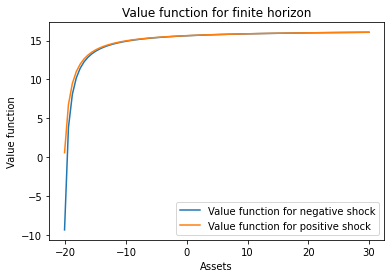

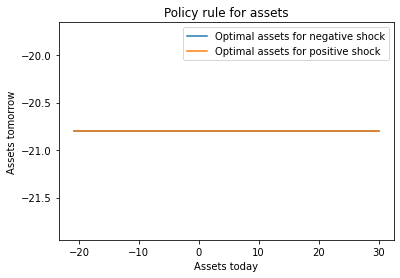

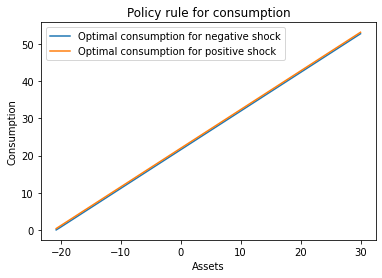

In [18]:
W = np.zeros((160, 80))

count = 0

while count < 45:
    
    W = np.amax((M + beta*W), axis = 1)
    W = np.reshape(W,(160, 1))
    W = W*np.ones((160, 80))
    
    count += 1

plt.plot(A[1:], W[1:80, 1], label = 'Value function for negative shock')
plt.plot(A[1:], W[81:, 1], label = 'Value function for positive shock')
plt.title('Value function for finite horizon')
plt.legend()
plt.ylabel('Value function')
plt.xlabel('Assets')
plt.show()

X = M + beta*W
g = np.argmax(X, axis = 1)

aopt_y1 = A[g[0:80]]     # optimal decision of assets given y1
aopt_y2 = A[g[80:]]      # optimal decision of assets given y2

c_y1 = Y[0]*np.ones(80) + (1+r)*A - aopt_y1

c_y2 = Y[1]*np.ones(80) + (1+r)*A - aopt_y2

for i in range(0, 80):
    
    if c_y1[i] < 0:
        
        c_y1[i] = 0
        
    if c_y2[i] < 0:
        
        c_y2[i] = 0
        
plt.figure()
plt.plot(A, aopt_y1, label = 'Optimal assets for negative shock')
plt.plot(A, aopt_y2, label = 'Optimal assets for positive shock')
plt.title('Policy rule for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y1, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y2, label = 'Optimal consumption for positive shock')
plt.title('Policy rule for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()